[INFO] Loaded datasets — Train+Val: (36373, 24), Test: (9093, 24)
[INFO] Creating ROI-based 3-class label (label_roi3).
[INFO] Finished preprocessing. Label distribution (train):
label_roi3
Flop       4205
Average    1681
Hit        1320
Name: count, dtype: int64



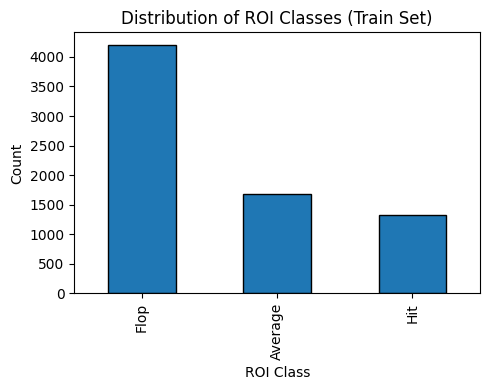

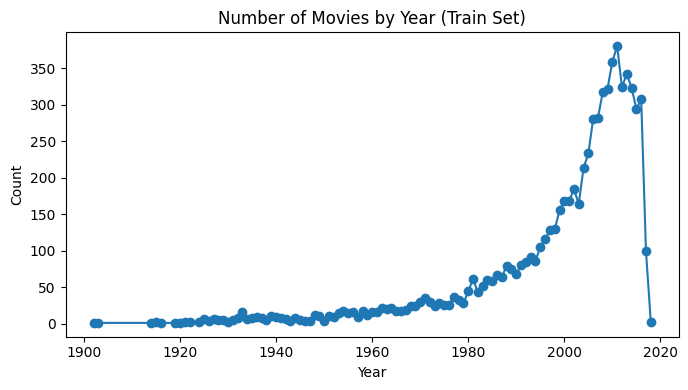

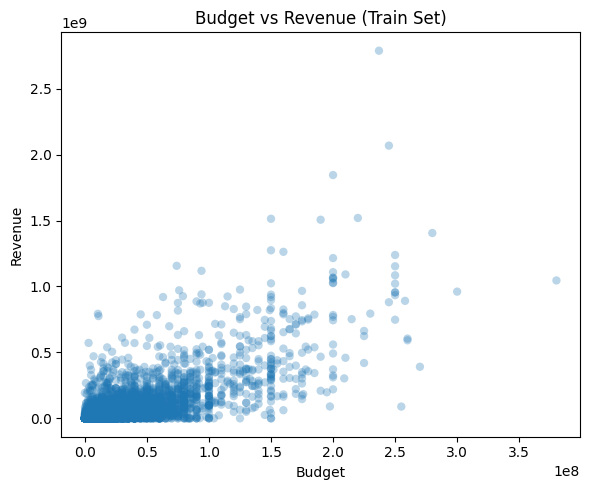

[INFO] Numeric features: ['budget', 'revenue', 'year', 'month', 'popularity', 'vote_average', 'vote_count', 'runtime']
[INFO] Categorical features: ['primary_genre', 'original_language', 'status']

[PART] Stand-alone classical models

  -> Training LogisticRegression ...
     LogisticRegression Accuracy = 0.999406, F1_macro = 0.999077

  -> Training RandomForest ...
     RandomForest Accuracy = 0.896675, F1_macro = 0.866589

  -> Training KNN ...
     KNN Accuracy = 0.981591, F1_macro = 0.975377

  -> Training SVM_RBF ...
     SVM_RBF Accuracy = 0.929335, F1_macro = 0.917645

  -> Training GradientBoosting ...
     GradientBoosting Accuracy = 0.972090, F1_macro = 0.963708

[PART] Tang 2024 Optimized XGBoost (RandomizedSearchCV)
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[RESULT] Tang_XGBoost Accuracy = 0.982185, F1_macro = 0.976778

[PART] Gupta-style ensemble models (Voting & Stacking)

  -> Training Voting ensemble ...
     Voting Accuracy = 0.993468, F1_macro = 0.9

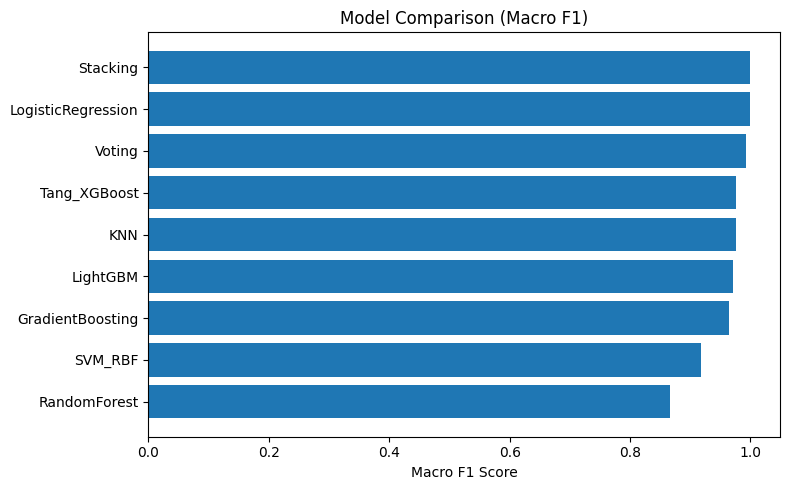

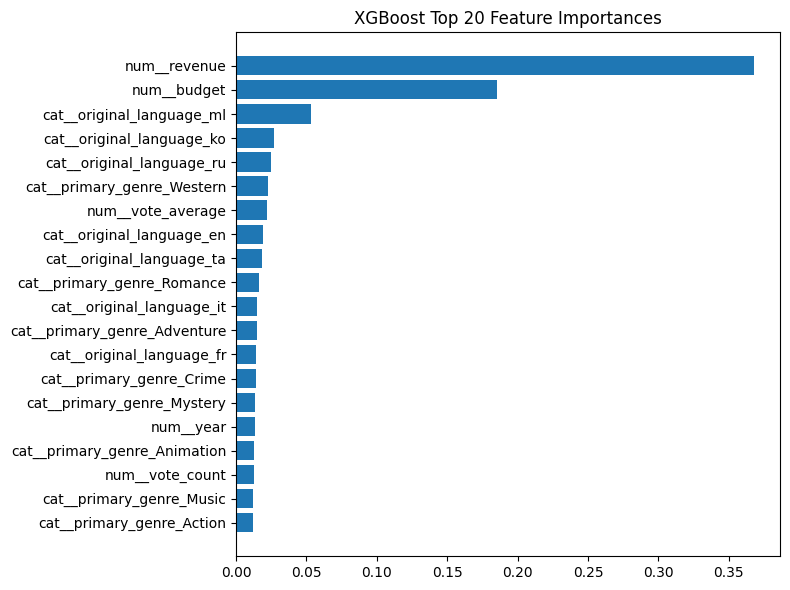

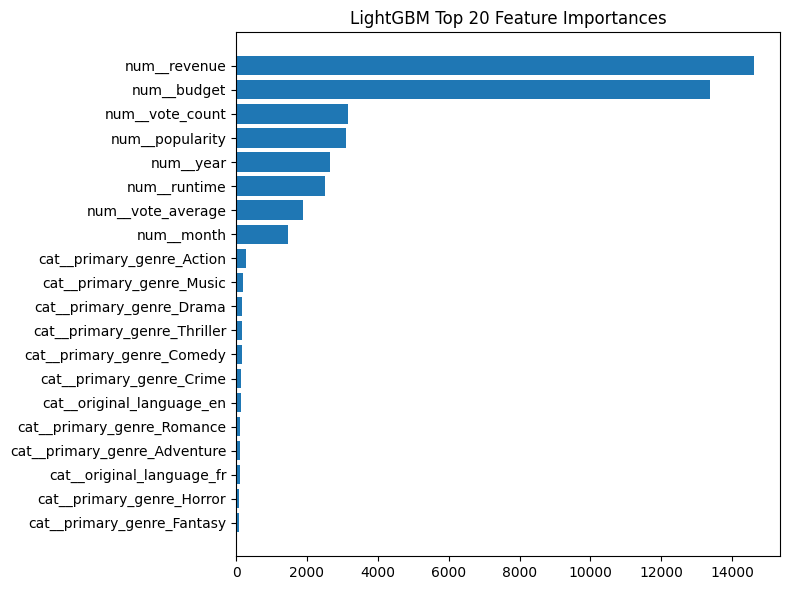

[INFO] Confusion matrix for best model: LogisticRegression


<Figure size 500x500 with 0 Axes>

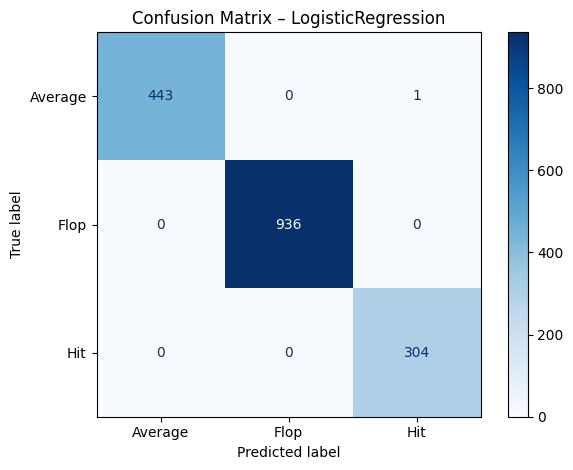


[INFO] All done. Figures saved as PNG files in the current folder.


In [2]:
"""
Final Project Code: Movie Box Office ROI Classification
=======================================================

Implements the experimental framework described in:

  "Movie Revenue Prediction Using Machine Learning Models"
  Jizhou Cheng, Pinrui Chen, DS 340W, Penn State (2024)

Data:
  Pre-processed splits from Kaggle "The Movies Dataset":
    - train_movies.csv
    - validation_movies.csv
    - test_movies.csv

Task:
  3-class ROI prediction (Hit / Average / Flop) based on movie metadata.

Models:
  - Classical: Logistic Regression, Random Forest, KNN, SVM (RBF),
               Gradient Boosting.
  - Tang-style Optimized XGBoost (RandomizedSearchCV).
  - Gupta-style Voting & Stacking ensembles.
  - Novel model: LightGBM.
  - (Optional) Optuna-optimized XGBoost.

Evaluation:
  - Accuracy
  - Macro-averaged F1-score

Visualization:
  - ROI class distribution (bar plot).
  - Model performance comparison (macro F1 bar plot).
  - Feature importance: XGBoost & LightGBM (if available).
  - Confusion matrix of the best model.
  - Time series: number of movies per year.
  - Scatter: Budget vs Revenue.

To run:
  1) Put this file in the same folder as the CSV files.
  2) Install required packages:
        pip install numpy pandas scikit-learn matplotlib xgboost lightgbm
  3) Run:
        python final_movie_roi_project.py
"""

import warnings
warnings.filterwarnings("ignore")

import json
import ast
from typing import Dict, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    ConfusionMatrixDisplay,
)

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    VotingClassifier,
    StackingClassifier,
)
from sklearn.neighbors import KNeighborsClassifier

# Optional gradient boosting libraries
try:
    import xgboost as xgb
except Exception:
    xgb = None
    print("[WARN] xgboost not installed. Run: pip install xgboost")

try:
    from lightgbm import LGBMClassifier
except Exception:
    LGBMClassifier = None
    print("[WARN] lightgbm not installed. Run: pip install lightgbm")

try:
    import optuna
except Exception:
    optuna = None  # Optional only


# ----------------------------------------------------------------------
# 1. Data loading & preprocessing
# ----------------------------------------------------------------------


def parse_primary_genre(genres_cell):
    """
    Parse the first genre from a TMDB-style "genres" JSON/list column.

    Examples of genres_cell:
        '[{"id": 18, "name": "Drama"}, {"id": 80, "name": "Crime"}]'
        '["Drama", "Crime"]'
        np.nan
    """
    if pd.isna(genres_cell):
        return "Unknown"

    try:
        if isinstance(genres_cell, str):
            try:
                val = json.loads(genres_cell)
            except Exception:
                val = ast.literal_eval(genres_cell)
        else:
            val = genres_cell

        if isinstance(val, list) and len(val) > 0:
            first = val[0]
            if isinstance(first, dict) and "name" in first:
                return first["name"]
            if isinstance(first, str):
                return first

        if isinstance(val, dict) and "name" in val:
            return val["name"]

        return str(val)
    except Exception:
        return "Unknown"


def build_roi_label(df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute ROI and map into 3-class labels:

        ROI = (revenue - budget) / budget

        ROI >= 2.5567   → "Hit"
        ROI <  0.0049   → "Flop"
        else            → "Average"
    """

    df["budget"] = pd.to_numeric(df["budget"], errors="coerce")
    df["revenue"] = pd.to_numeric(df["revenue"], errors="coerce")

    df["ROI"] = (df["revenue"] - df["budget"]) / df["budget"]
    df["ROI"] = df["ROI"].replace([np.inf, -np.inf], np.nan)

    def roi_to_class(roi):
        if pd.isna(roi):
            return np.nan
        if roi >= 2.5567:
            return "Hit"
        if roi < 0.0049:
            return "Flop"
        return "Average"

    df["label_roi3"] = df["ROI"].apply(roi_to_class)
    return df


def load_and_preprocess(
    train_path: str,
    val_path: str,
    test_path: str,
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Load train/val/test CSV files and perform preprocessing:

      - Merge train + validation into a single training set.
      - Parse release_date into year / month.
      - Extract primary_genre from "genres".
      - Compute 3-class ROI label: Hit / Average / Flop.
    """

    train = pd.read_csv(train_path)
    val = pd.read_csv(val_path)
    test = pd.read_csv(test_path)

    train = pd.concat([train, val], ignore_index=True)
    print(f"[INFO] Loaded datasets — Train+Val: {train.shape}, Test: {test.shape}")

    # time features
    if "release_date" in train.columns:
        train["release_date"] = pd.to_datetime(train["release_date"], errors="coerce")
    if "release_date" in test.columns:
        test["release_date"] = pd.to_datetime(test["release_date"], errors="coerce")

    for df, default_year in [(train, 2015), (test, 2016)]:
        if "release_date" in df.columns:
            df["year"] = df["release_date"].dt.year
            df["month"] = df["release_date"].dt.month
        df["year"] = pd.to_numeric(df.get("year", default_year), errors="coerce").fillna(default_year)
        df["month"] = pd.to_numeric(df.get("month", 6), errors="coerce").fillna(6)

    # primary genre
    if "primary_genre" not in train.columns:
        if "genres" in train.columns:
            train["primary_genre"] = train["genres"].apply(parse_primary_genre)
        else:
            train["primary_genre"] = "Unknown"

    if "primary_genre" not in test.columns:
        if "genres" in test.columns:
            test["primary_genre"] = test["genres"].apply(parse_primary_genre)
        else:
            test["primary_genre"] = "Unknown"

    # ROI label
    if "label_roi3" not in train.columns:
        print("[INFO] Creating ROI-based 3-class label (label_roi3).")
        train = build_roi_label(train)
        test = build_roi_label(test)

    train = train.dropna(subset=["label_roi3"]).reset_index(drop=True)
    test = test.dropna(subset=["label_roi3"]).reset_index(drop=True)

    # numeric cast
    numeric_cols = ["budget", "revenue", "year", "month", "popularity",
                    "vote_average", "vote_count", "runtime"]
    for col in numeric_cols:
        if col in train.columns:
            train[col] = pd.to_numeric(train[col], errors="coerce")
        if col in test.columns:
            test[col] = pd.to_numeric(test[col], errors="coerce")

    print("[INFO] Finished preprocessing. Label distribution (train):")
    print(train["label_roi3"].value_counts())
    print()

    return train, test


# ----------------------------------------------------------------------
# 2. Model training
# ----------------------------------------------------------------------


def train_all_models(
    train: pd.DataFrame,
    test: pd.DataFrame,
    random_state: int = 42,
    use_optuna: bool = False,
    n_optuna_trials: int = 20,
):
    """
    Train all models and return:
      - results: dict[model_name -> metrics dict]
      - fitted_models: dict[model_name -> trained Pipeline]
      - X_test, y_test_enc, label_encoder, feature_names
    """

    target_col = "label_roi3"

    numeric_candidates = [
        "budget", "revenue", "year", "month",
        "popularity", "vote_average", "vote_count", "runtime",
    ]
    categorical_candidates = ["primary_genre", "original_language", "status"]

    num_features = [c for c in numeric_candidates if c in train.columns]
    cat_features = [c for c in categorical_candidates if c in train.columns]

    if len(num_features) == 0:
        raise ValueError("No numeric features found. Check column names.")

    print("[INFO] Numeric features:", num_features)
    print("[INFO] Categorical features:", cat_features)

    X_train = train[num_features + cat_features].copy()
    X_test = test[num_features + cat_features].copy()
    y_train = train[target_col].copy()
    y_test = test[target_col].copy()

    # Encode labels for all models (simplifies metrics & confusion matrix)
    le = LabelEncoder()
    y_train_enc = le.fit_transform(y_train)
    y_test_enc = le.transform(y_test)

    # preprocessing
    num_tf = Pipeline([("imp", SimpleImputer(strategy="median"))])
    cat_tf = Pipeline([
        ("imp", SimpleImputer(strategy="most_frequent")),
        ("oh", OneHotEncoder(handle_unknown="ignore")),
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", num_tf, num_features),
            ("cat", cat_tf, cat_features),
        ]
    )

    results: Dict[str, Dict[str, float]] = {}
    fitted_models: Dict[str, Pipeline] = {}

    # 2.1 classical models
    print("\n[PART] Stand-alone classical models")

    classical_models = {
        "LogisticRegression": LogisticRegression(max_iter=500),
        "RandomForest": RandomForestClassifier(n_estimators=300, random_state=random_state),
        "KNN": KNeighborsClassifier(n_neighbors=15),
        "SVM_RBF": SVC(
            kernel="rbf", C=2.0, gamma="scale", probability=True, random_state=random_state
        ),
        "GradientBoosting": GradientBoostingClassifier(
            n_estimators=300, learning_rate=0.05, random_state=random_state
        ),
    }

    for name, clf in classical_models.items():
        print(f"\n  -> Training {name} ...")
        pipe = Pipeline([("pre", preprocessor), ("clf", clf)])
        pipe.fit(X_train, y_train_enc)
        preds = pipe.predict(X_test)

        acc = accuracy_score(y_test_enc, preds)
        f1 = f1_score(y_test_enc, preds, average="macro")
        results[name] = {"Accuracy": acc, "F1_macro": f1}
        fitted_models[name] = pipe

        print(f"     {name} Accuracy = {acc:.6f}, F1_macro = {f1:.6f}")

    # 2.2 Tang-style XGBoost
    if xgb is not None:
        print("\n[PART] Tang 2024 Optimized XGBoost (RandomizedSearchCV)")

        xgb_clf = xgb.XGBClassifier(
            objective="multi:softprob",
            num_class=len(le.classes_),
            eval_metric="mlogloss",
            random_state=random_state,
            n_estimators=300,
        )
        pipe_xgb = Pipeline([("pre", preprocessor), ("xgb", xgb_clf)])

        param_dist = {
            "xgb__max_depth": [3, 4, 5, 6],
            "xgb__learning_rate": [0.02, 0.05, 0.1],
            "xgb__subsample": [0.8, 1.0],
            "xgb__colsample_bytree": [0.8, 1.0],
            "xgb__min_child_weight": [1, 3, 5],
        }

        search = RandomizedSearchCV(
            estimator=pipe_xgb,
            param_distributions=param_dist,
            n_iter=10,
            scoring="f1_macro",
            cv=3,
            n_jobs=-1,
            verbose=1,
            random_state=random_state,
        )
        search.fit(X_train, y_train_enc)
        best_xgb = search.best_estimator_

        preds_enc = best_xgb.predict(X_test)
        acc = accuracy_score(y_test_enc, preds_enc)
        f1 = f1_score(y_test_enc, preds_enc, average="macro")

        results["Tang_XGBoost"] = {"Accuracy": acc, "F1_macro": f1}
        fitted_models["Tang_XGBoost"] = best_xgb

        print(f"[RESULT] Tang_XGBoost Accuracy = {acc:.6f}, F1_macro = {f1:.6f}")
    else:
        print("\n[WARN] Skipping Tang_XGBoost (xgboost not installed).")

    # 2.3 Gupta-style ensembles
    print("\n[PART] Gupta-style ensemble models (Voting & Stacking)")

    lr = classical_models["LogisticRegression"]
    svm = classical_models["SVM_RBF"]
    rf = classical_models["RandomForest"]
    gb = classical_models["GradientBoosting"]
    knn = classical_models["KNN"]

    base_estimators = [("lr", lr), ("svm", svm), ("rf", rf), ("gb", gb), ("knn", knn)]

    # Voting
    vote_clf = VotingClassifier(estimators=base_estimators, voting="soft")
    pipe_vote = Pipeline([("pre", preprocessor), ("ens", vote_clf)])
    print("\n  -> Training Voting ensemble ...")
    pipe_vote.fit(X_train, y_train_enc)
    preds_vote = pipe_vote.predict(X_test)
    acc_vote = accuracy_score(y_test_enc, preds_vote)
    f1_vote = f1_score(y_test_enc, preds_vote, average="macro")
    results["Voting"] = {"Accuracy": acc_vote, "F1_macro": f1_vote}
    fitted_models["Voting"] = pipe_vote
    print(f"     Voting Accuracy = {acc_vote:.6f}, F1_macro = {f1_vote:.6f}")

    # Stacking
    stack_clf = StackingClassifier(
        estimators=base_estimators,
        final_estimator=LogisticRegression(max_iter=500),
        stack_method="predict_proba",
    )
    pipe_stack = Pipeline([("pre", preprocessor), ("ens", stack_clf)])
    print("\n  -> Training Stacking ensemble ...")
    pipe_stack.fit(X_train, y_train_enc)
    preds_stack = pipe_stack.predict(X_test)
    acc_stack = accuracy_score(y_test_enc, preds_stack)
    f1_stack = f1_score(y_test_enc, preds_stack, average="macro")
    results["Stacking"] = {"Accuracy": acc_stack, "F1_macro": f1_stack}
    fitted_models["Stacking"] = pipe_stack
    print(f"     Stacking Accuracy = {acc_stack:.6f}, F1_macro = {f1_stack:.6f}")

    # 2.4 LightGBM
    if LGBMClassifier is not None:
        print("\n[PART] Novel model: LightGBM")
        lgbm = LGBMClassifier(
            n_estimators=500,
            learning_rate=0.05,
            max_depth=-1,
            num_leaves=31,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=random_state,
        )
        pipe_lgbm = Pipeline([("pre", preprocessor), ("lgbm", lgbm)])
        pipe_lgbm.fit(X_train, y_train_enc)
        preds_lgbm = pipe_lgbm.predict(X_test)
        acc_lgbm = accuracy_score(y_test_enc, preds_lgbm)
        f1_lgbm = f1_score(y_test_enc, preds_lgbm, average="macro")
        results["LightGBM"] = {"Accuracy": acc_lgbm, "F1_macro": f1_lgbm}
        fitted_models["LightGBM"] = pipe_lgbm
        print(f"[RESULT] LightGBM Accuracy = {acc_lgbm:.6f}, F1_macro = {f1_lgbm:.6f}")
    else:
        print("\n[WARN] Skipping LightGBM (lightgbm not installed).")

    # 2.5 Optional Optuna-XGBoost
    if use_optuna and (optuna is not None) and (xgb is not None):
        print("\n[PART] Optuna-optimized XGBoost ...")

        def objective(trial):
            params = {
                "max_depth": trial.suggest_int("max_depth", 3, 10),
                "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
                "subsample": trial.suggest_float("subsample", 0.5, 1.0),
                "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
                "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
                "n_estimators": trial.suggest_int("n_estimators", 200, 500),
            }
            clf = xgb.XGBClassifier(
                objective="multi:softprob",
                num_class=len(le.classes_),
                eval_metric="mlogloss",
                random_state=random_state,
                **params,
            )
            pipe = Pipeline([("pre", preprocessor), ("xgb", clf)])
            scores = cross_val_score(
                pipe, X_train, y_train_enc, cv=3, scoring="f1_macro", n_jobs=-1
            )
            return scores.mean()

        study = optuna.create_study(direction="maximize")
        study.optimize(objective, n_trials=n_optuna_trials)
        best_params = study.best_params
        print("[INFO] Best Optuna params:", best_params)

        clf_opt = xgb.XGBClassifier(
            objective="multi:softprob",
            num_class=len(le.classes_),
            eval_metric="mlogloss",
            random_state=random_state,
            **best_params,
        )
        pipe_opt = Pipeline([("pre", preprocessor), ("xgb", clf_opt)])
        pipe_opt.fit(X_train, y_train_enc)
        preds_opt = pipe_opt.predict(X_test)
        acc_opt = accuracy_score(y_test_enc, preds_opt)
        f1_opt = f1_score(y_test_enc, preds_opt, average="macro")
        results["Optuna_XGBoost"] = {"Accuracy": acc_opt, "F1_macro": f1_opt}
        fitted_models["Optuna_XGBoost"] = pipe_opt
        print(f"[RESULT] Optuna_XGBoost Accuracy = {acc_opt:.6f}, F1_macro = {f1_opt:.6f}")
    elif use_optuna:
        print("\n[WARN] Optuna requested but library/xgboost missing — skipping.")

    # Needed information for plotting feature importances
    # We can get feature names from any fitted pipeline's preprocessor.
    example_pipe = next(iter(fitted_models.values()))
    feature_names = example_pipe.named_steps["pre"].get_feature_names_out()

    return results, fitted_models, X_test, y_test_enc, le, feature_names


# ----------------------------------------------------------------------
# 3. Visualization helpers
# ----------------------------------------------------------------------


def plot_class_distribution(train: pd.DataFrame):
    plt.figure(figsize=(5, 4))
    train["label_roi3"].value_counts().plot(
        kind="bar", edgecolor="black"
    )
    plt.title("Distribution of ROI Classes (Train Set)")
    plt.xlabel("ROI Class")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig("fig_roi_class_distribution.png", dpi=300)
    plt.show()


def summarize_results(results: Dict[str, Dict[str, float]]) -> pd.DataFrame:
    df = pd.DataFrame(results).T  # models as rows
    if "F1_macro" in df.columns:
        df = df.sort_values("F1_macro", ascending=False)

    print("\n================ FINAL COMPARISON ================")
    print(df)
    print("==================================================")

    if "F1_macro" in df.columns:
        best_model = df["F1_macro"].idxmax()
        best_f1 = df["F1_macro"].max()
        print(f"\n[INFO] Best model by F1_macro: {best_model} → {best_f1:.6f}")
    return df


def plot_model_performance(df_results: pd.DataFrame):
    plt.figure(figsize=(8, 5))
    df_sorted = df_results.sort_values("F1_macro")
    plt.barh(df_sorted.index, df_sorted["F1_macro"])
    plt.xlabel("Macro F1 Score")
    plt.title("Model Comparison (Macro F1)")
    plt.tight_layout()
    plt.savefig("fig_model_performance.png", dpi=300)
    plt.show()


def plot_feature_importance_xgb(pipe_xgb: Pipeline, feature_names):
    if pipe_xgb is None:
        return
    if "xgb" not in pipe_xgb.named_steps:
        return
    model = pipe_xgb.named_steps["xgb"]
    importances = model.feature_importances_
    idx = np.argsort(importances)[::-1][:20]

    plt.figure(figsize=(8, 6))
    plt.barh(np.array(feature_names)[idx], importances[idx])
    plt.gca().invert_yaxis()
    plt.title("XGBoost Top 20 Feature Importances")
    plt.tight_layout()
    plt.savefig("fig_xgb_feature_importance.png", dpi=300)
    plt.show()


def plot_feature_importance_lgbm(pipe_lgbm: Pipeline, feature_names):
    if pipe_lgbm is None:
        return
    if "lgbm" not in pipe_lgbm.named_steps:
        return
    model = pipe_lgbm.named_steps["lgbm"]
    importances = model.feature_importances_
    idx = np.argsort(importances)[::-1][:20]

    plt.figure(figsize=(8, 6))
    plt.barh(np.array(feature_names)[idx], importances[idx])
    plt.gca().invert_yaxis()
    plt.title("LightGBM Top 20 Feature Importances")
    plt.tight_layout()
    plt.savefig("fig_lgbm_feature_importance.png", dpi=300)
    plt.show()


def plot_confusion_matrix_best(
    best_name: str,
    fitted_models: Dict[str, Pipeline],
    X_test: pd.DataFrame,
    y_test_enc: np.ndarray,
    label_encoder: LabelEncoder,
):
    pipe = fitted_models[best_name]
    preds = pipe.predict(X_test)
    y_true_labels = label_encoder.inverse_transform(y_test_enc)
    y_pred_labels = label_encoder.inverse_transform(preds)

    plt.figure(figsize=(5, 5))
    ConfusionMatrixDisplay.from_predictions(
        y_true_labels,
        y_pred_labels,
        cmap="Blues",
        values_format="d",
    )
    plt.title(f"Confusion Matrix – {best_name}")
    plt.tight_layout()
    plt.savefig("fig_confusion_matrix_best.png", dpi=300)
    plt.show()


def plot_time_series_and_scatter(train: pd.DataFrame):
    # Movies per year
    plt.figure(figsize=(7, 4))
    (
        train.groupby("year")
        .size()
        .plot(kind="line", marker="o")
    )
    plt.title("Number of Movies by Year (Train Set)")
    plt.xlabel("Year")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig("fig_movies_per_year.png", dpi=300)
    plt.show()

    # Budget vs Revenue scatter (may need log-scale if extreme values)
    plt.figure(figsize=(6, 5))
    plt.scatter(
        train["budget"],
        train["revenue"],
        alpha=0.3,
        edgecolor="none",
    )
    plt.xlabel("Budget")
    plt.ylabel("Revenue")
    plt.title("Budget vs Revenue (Train Set)")
    plt.tight_layout()
    plt.savefig("fig_budget_vs_revenue.png", dpi=300)
    plt.show()


# ----------------------------------------------------------------------
# 4. Main
# ----------------------------------------------------------------------


def main():
    TRAIN_PATH = "train_movies.csv"
    VAL_PATH = "validation_movies.csv"
    TEST_PATH = "test_movies.csv"

    # 1) Load & preprocess
    train_df, test_df = load_and_preprocess(TRAIN_PATH, VAL_PATH, TEST_PATH)

    # 2) Basic exploratory plots
    plot_class_distribution(train_df)
    plot_time_series_and_scatter(train_df)

    # 3) Train all models
    USE_OPTUNA = False  # set True if optuna + xgboost installed and you want extra search
    results, fitted_models, X_test, y_test_enc, le, feature_names = train_all_models(
        train=train_df,
        test=test_df,
        random_state=42,
        use_optuna=USE_OPTUNA,
        n_optuna_trials=20,
    )

    # 4) Summarize & save results
    summary_df = summarize_results(results)
    summary_df.to_csv("model_performance_summary.csv", index=True)
    plot_model_performance(summary_df)

    # 5) Feature importance plots
    pipe_xgb = fitted_models.get("Tang_XGBoost", None)
    if pipe_xgb is not None:
        plot_feature_importance_xgb(pipe_xgb, feature_names)

    pipe_lgbm = fitted_models.get("LightGBM", None)
    if pipe_lgbm is not None:
        plot_feature_importance_lgbm(pipe_lgbm, feature_names)

    # 6) Confusion matrix of the best model
    if "F1_macro" in summary_df.columns:
        best_model_name = summary_df["F1_macro"].idxmax()
        print(f"[INFO] Confusion matrix for best model: {best_model_name}")
        plot_confusion_matrix_best(
            best_model_name,
            fitted_models,
            X_test,
            y_test_enc,
            le,
        )

    print("\n[INFO] All done. Figures saved as PNG files in the current folder.")


if __name__ == "__main__":
    main()
